In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from delphi.utils import constants as consts
from delphi import oracle
from delphi import train
from delphi.utils import defaults
import datetime

## Default Experiment Parameters

In [274]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'custom_lr_multiplier': consts.COSINE,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
})

# Generate Synthetic Data

In [233]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

ground truth weights: Parameter containing:
tensor([[ 1.7296e-03, -3.4988e-04],
        [ 7.7029e-01, -9.2286e-01]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([0.3710, 0.4608], requires_grad=True)


# Untruncated Experiment

In [203]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # retain logits of kth class
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        out = noised.mean(dim=0)
        # calculate gradient 
        grad = 1 - ch.exp(-out)
        return grad / pred.size(0), -grad / pred.size(0)

# Algorithm Parameters

In [283]:
# all synthetic data 
ds = TensorDataset(X, y)
# split ds into training and validation data sets
train_length = int(len(ds)*.8)
val_length = len(ds) - train_length
train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
# train and validation loaders
train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)
# gradients
gumbel_ce = GumbelCE.apply
ce_loss = nn.CrossEntropyLoss()

# PyTorch CE Loss

In [284]:
# CE LOSS TABLE FOR METRICS
CE_LOSS_TABLE_NAME = 'ce_loss'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(CE_LOSS_TABLE_NAME, { 
    'train_acc': float, 
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/e919d3ab-a15a-43ce-9da2-01436d1fa937


In [285]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

for epoch in range(args.epochs): 
    # train loop
    train_loss, train_acc = Tensor([]), Tensor([])
    for batch_X, batch_y in train_loader: 
        optimizer.zero_grad()
        pred = multi_log_reg(batch_X)
        loss = ce_loss(pred,  batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # keep track of algorithm training loss and accuracy
        acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
        train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
        train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
    # validation loop
    val_loss, val_acc = Tensor([]), Tensor([])
    with ch.no_grad(): 
        for batch_X, batch_y in val_loader: 
            pred = multi_log_reg(batch_X)
            loss = ce_loss(pred, batch_y)
            # keep track of algorithm validation loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
            val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
            val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])
            
    store[CE_LOSS_TABLE_NAME].append_row({ 
        'train_acc': float(train_acc.mean()), 
        'val_acc': float(val_acc.mean()), 
        'train_loss': float(train_loss.mean()), 
        'val_loss': float(val_loss.mean()),
        'epoch': int(epoch + 1),
    })
store.close()

# Read Results Experiment

In [286]:
reader = CollectionReader(STORE_PATH)
results = reader.df(CE_LOSS_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 120.96it/s]


,train_acc,val_acc,train_loss,val_loss,epoch,exp_id
0,0.909750,0.9725,0.259190,0.134913,1,e919d3ab-a15a-43ce-9da2-01436d1fa937
1,0.980625,0.9890,0.120366,0.099821,2,e919d3ab-a15a-43ce-9da2-01436d1fa937
2,0.989875,0.9905,0.098150,0.088248,3,e919d3ab-a15a-43ce-9da2-01436d1fa937
3,0.992375,0.9945,0.086820,0.078112,4,e919d3ab-a15a-43ce-9da2-01436d1fa937
4,0.995000,0.9965,0.079516,0.072825,5,e919d3ab-a15a-43ce-9da2-01436d1fa937


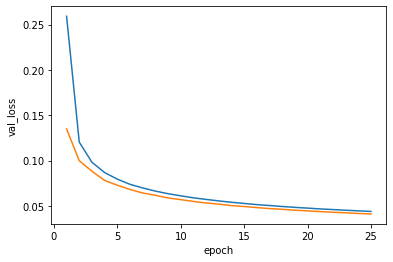

In [288]:
sns.lineplot(data=results, x='epoch', y='train_loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color=)

In [279]:
results

,train_acc,val_acc,train_loss,val_loss,exp_id,epoch
0,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
1,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
2,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
3,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
4,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
5,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
6,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
7,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
8,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN
9,0.635625,0.6460,0.972551,0.943667,890faf71-cdda-4064-9063-190e2d73a252,NaN


# All Trials

In [214]:
loss = ch.nn.CrossEntropyLoss()
in_ = ch.randn(3, 5, requires_grad=True)
targ = ch.empty(3, dtype=ch.long).random_(5)
output = loss(in_, targ)
output.backward()

all trials:


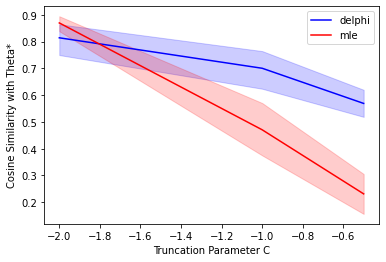

In [8]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

In [75]:
noised = Tensor([[[ 1.0560, -3.8584],
         [-1.2214, -0.9489]],

        [[-1.6712, -1.9533],
         [-0.8944, -1.4495]],

        [[-1.8983, -4.0983],
         [-1.4501, -1.9598]],

        [[-0.9539, -2.2767],
         [ 2.5476,  0.4471]],

        [[-2.2341, -2.2865],
         [-1.7169,  0.2144]],

        [[-1.4339, -0.3059],
         [ 0.4510, -1.4590]],

        [[-2.0107, -1.3643],
         [-1.5716,  0.3137]],

        [[-0.7560, -1.4000],
         [-0.9327,  0.1150]],

        [[-2.0108, -2.5165],
         [-0.3383, -0.6087]],

        [[-0.0648, -2.7537],
         [ 1.7234,  1.9073]],

        [[-1.8798, -3.3068],
         [-0.7087, -2.4642]],

        [[-0.2455, -2.1626],
         [-0.3371,  0.0180]],

        [[-2.5813, -2.4287],
         [-0.9224, -2.1847]],

        [[-1.0940, -1.9071],
         [ 0.8468, -2.3331]],

        [[-3.2971, -2.0524],
         [-1.4311, -1.1494]],

        [[-2.6149, -2.6758],
         [-0.7592, -1.1986]],

        [[-2.3288, -1.5224],
         [-0.8951, -0.9140]],

        [[-2.7542, -2.8087],
         [-0.5657, -1.4403]],

        [[-3.4988, -3.0018],
         [ 0.5731, -2.2174]],

        [[-2.4198, -2.1155],
         [-0.5168, -0.5764]],

        [[-2.1924, -3.0091],
         [ 2.0917, -2.6498]],

        [[-1.8525, -0.2391],
         [ 1.7617, -0.2672]],

        [[ 0.7369, -3.4856],
         [-0.5979, -0.7600]],

        [[-2.6055, -2.1767],
         [ 1.0593, -1.3477]],

        [[-0.5726, -0.1534],
         [ 1.0499,  0.4263]],

        [[-1.9888, -3.9787],
         [ 0.4091, -1.4149]],

        [[-1.8296, -2.3222],
         [-0.8472, -0.3118]],

        [[-0.6744, -2.4931],
         [ 2.2560,  0.3748]],

        [[-1.8801, -1.6657],
         [ 3.2183, -1.6286]],

        [[-2.2326, -1.1349],
         [-0.0596, -2.0473]],

        [[-1.3548,  0.5576],
         [ 1.9920,  0.9339]],

        [[-2.8249, -3.0318],
         [-1.1114,  0.5785]],

        [[-1.7085, -1.1466],
         [-0.8857, -0.5736]],

        [[-1.8164, -1.7708],
         [-0.1024,  0.0766]],

        [[-3.0525, -1.9988],
         [ 0.5441, -0.7982]],

        [[-1.7448, -3.1155],
         [ 2.2486, -1.5342]],

        [[-1.9477, -0.1934],
         [ 0.5465, -2.5079]],

        [[-2.6963, -0.2418],
         [ 1.2172,  0.7050]],

        [[-1.8903, -2.9712],
         [ 0.4166, -1.2514]],

        [[-2.0709, -3.1687],
         [ 2.5223, -0.2994]],

        [[-1.8679, -2.7461],
         [-0.6421, -1.9754]],

        [[-2.7887, -2.1825],
         [ 0.0998, -1.3368]],

        [[-3.1074, -0.7717],
         [-0.2210, -0.3437]],

        [[-1.9947, -2.9064],
         [ 0.2664,  1.2022]],

        [[-0.9560, -3.1553],
         [ 1.3751, -1.0426]],

        [[-1.5139, -2.3713],
         [ 2.0548, -0.8236]],

        [[-1.4052, -2.0388],
         [ 1.4332, -0.8124]],

        [[-3.2574, -1.5598],
         [ 1.5965, -1.2019]],

        [[-2.8377, -2.6667],
         [ 1.1232, -1.3367]],

        [[-0.4928, -1.8704],
         [-1.4774,  1.0796]],

        [[-2.6414, -3.4802],
         [ 0.6802, -0.9123]],

        [[-0.8694, -2.9267],
         [ 0.2714,  0.4229]],

        [[-0.4967, -1.5111],
         [-0.2160, -1.1178]],

        [[-1.2289, -2.3436],
         [-1.8865, -1.8925]],

        [[-1.6669, -1.7328],
         [-1.2724,  0.2138]],

        [[-1.4756, -2.7216],
         [ 1.1949,  0.5571]],

        [[ 0.6502, -1.1516],
         [-0.7539, -0.5960]],

        [[-2.3657, -2.1644],
         [-1.7881, -0.6049]],

        [[ 0.1235, -2.4216],
         [-1.6703, -0.6570]],

        [[-1.6081, -2.5614],
         [-1.4984, -1.7102]],

        [[-2.1091, -2.8839],
         [-0.0275, -1.1736]],

        [[ 3.6756, -3.6225],
         [-1.2882, -1.1626]],

        [[-2.6822, -2.9475],
         [-0.2061, -1.2934]],

        [[-2.4984, -1.7418],
         [-0.3344, -0.4563]],

        [[-1.7352, -0.3297],
         [-0.2656, -1.8673]],

        [[-1.6158, -3.4096],
         [-0.6524, -0.5965]],

        [[-0.6415, -2.5327],
         [-1.2740,  0.0516]],

        [[-2.1714,  1.0943],
         [-1.2717, -0.3700]],

        [[-2.9328, -3.7710],
         [-0.5234,  2.3529]],

        [[ 0.5606, -2.2174],
         [-1.5207, -1.3377]],

        [[-2.7490, -2.1677],
         [-0.5915,  2.9936]],

        [[-2.1826, -1.7886],
         [-1.1068,  3.8118]],

        [[-1.1182, -1.6254],
         [-2.0043, -1.7129]],

        [[-2.1996, -3.4555],
         [-0.5052,  0.2362]],

        [[-2.7407, -2.7880],
         [-0.5743, -2.4324]],

        [[-0.1798, -3.5650],
         [ 0.7852, -1.0151]],

        [[-2.3234, -2.7063],
         [-1.3150, -1.1089]],

        [[-1.0531, -2.1752],
         [ 1.2345, -1.0169]],

        [[-2.1998, -2.9319],
         [-1.1831, -2.3023]],

        [[-1.7376, -2.5499],
         [ 0.8526, -0.1788]],

        [[-2.2441, -1.3225],
         [-2.1961, -0.6747]],

        [[ 0.5213,  0.4186],
         [-0.8650, -1.8961]],

        [[-2.4624,  4.6077],
         [-1.1862, -0.0901]],

        [[-2.7908, -2.5028],
         [-1.6535, -0.6785]],

        [[-0.2896, -3.4716],
         [-1.6044, -1.1113]],

        [[-0.4959, -2.1963],
         [-0.0990,  0.2970]],

        [[-1.4091, -4.3429],
         [ 0.7885, -1.0671]],

        [[ 0.1364, -2.6706],
         [ 0.1068, -2.5305]],

        [[-2.9902, -2.2973],
         [ 0.8453,  0.8639]],

        [[-2.5638, -2.7309],
         [ 3.1293,  0.4658]],

        [[-1.5934, -0.3429],
         [-0.9555,  0.0455]],

        [[-1.4570, -4.0055],
         [-0.2121,  1.3399]],

        [[-2.8397, -3.3605],
         [ 0.1341, -0.3108]],

        [[-1.0677, -1.8023],
         [-0.8705,  0.8179]],

        [[-1.3403, -1.8707],
         [ 0.8120, -0.0934]],

        [[-0.6316, -2.6508],
         [ 0.1277, -0.9488]],

        [[-2.3880, -2.4543],
         [-0.8413, -0.7747]],

        [[-2.8221, -2.7989],
         [-0.9182,  0.0289]],

        [[-0.3723, -4.1127],
         [-1.2239,  1.1183]],

        [[-0.4058, -2.8588],
         [ 0.0136, -1.2132]]])
targ = Tensor([1, 0])

In [79]:
noised[:, 0, 1].size()

# iterate over samples within batch
for i in range(noised.size(1)): 
    # get minimum noisy logit for kth class
    z_k_min = ch.min(noised[:, i, targ[i]])
    # remove all noisy logits that exceed minimum z_k_min
    noised[:, i, :targ[i]] = ()

torch.Size([100])

In [77]:
min_ = ch.min(noised[:, 0, 1])

In [46]:
noised[:, :, 1][noised[:, :, 1] > min_]

tensor([-6.6353e-01,  9.2454e-01, -1.3882e+00, -4.2077e-01, -5.1796e-01,
        -2.5875e-02,  1.1469e+00,  1.8420e+00, -7.8114e-01,  3.2464e+00,
        -4.9372e-01,  1.8196e+00, -1.4493e+00, -7.7102e-01, -1.8105e+00,
         1.9806e-01,  3.5968e-02, -1.1108e+00,  1.2389e+00,  5.5595e-01,
        -8.8794e-01,  5.0175e-01, -9.5006e-01, -6.9789e-01, -2.3972e-01,
        -2.5504e-01, -1.2480e-01, -2.0448e-01, -9.9472e-01,  7.7929e-01,
        -1.0189e+00, -8.8779e-01, -2.7169e-01,  9.3906e-01,  5.1272e-01,
         3.2421e+00,  6.3645e-01,  7.5989e-01,  6.5425e-01,  7.1514e-01,
        -4.8394e-01,  6.1486e-01,  1.8244e+00, -1.1723e+00, -6.3182e-01,
        -1.2484e+00,  2.0983e+00, -5.9039e-01,  1.1814e-03, -7.0837e-01,
         1.0561e+00, -3.5399e-01,  2.8613e+00,  9.9123e-01, -1.0549e+00,
        -6.8838e-01,  7.9036e-01, -4.3622e-01, -3.6478e-01, -3.9149e-01,
         1.1706e+00,  1.3072e+00, -3.3425e-01, -3.6908e-01,  1.9358e+00,
        -1.2103e+00, -1.0137e+00, -4.3369e-02,  1.1